<a href="https://colab.research.google.com/github/Spin-Chemistry-Labs/radicalpy/blob/187-google-colab-tutorials/examples/tutorials/04_density_matrices_and_time_evolution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Tutorial 4 - Density matrices and time evolution



&copy; Lewis M. Antill, 2025

This tutorial aims to introduce the key concept of the [density matrix](https://en.wikipedia.org/wiki/Density_matrix) and time evolution of a radical pair.

In [ ]:
!pip install radicalpy

In [1]:
import ipywidgets as wdg
import numpy as np
import matplotlib.pyplot as plt
import sympy as smp

import radicalpy as rp
from radicalpy.experiments import magnetic_field_loop
from radicalpy.kinetics import Haberkorn, HaberkornFree
from radicalpy.plot import plot_general
from radicalpy.relaxation import RandomFields, SingletTripletDephasing
from radicalpy.simulation import Molecule, HilbertSimulation, State

---

### Density matrix formalism

The density matrix formalism is a common tool in spin quantum mechanics. It allows one to describe and generalise large spin systems and their ensembles. Density matrices embody the idea of mixed states and allow one to describe the spin states and dynamics of magnetosensitive radical pair reactions. It also allows the description of the system's time evolution, MARY (magnetically affected reaction yield), and orientation dependence.

The superoperator formalism ([Liouville space](https://en.wikipedia.org/wiki/Liouville_space)) allows one to describe spin relaxation and chemical kinetics (both of which will be described in a future tutorial). For a system with *n* possible spins, the density operator $\hat{\rho}$ is,

$$
\hat{\rho} = \sum_{n,m}c_n c_m^*  |\psi_n\rangle \langle\psi_m|
$$

The density matrix is a *n*-dimensional matrix, $\rho$, where $\rho = \langle m|\hat{\rho}|n\rangle$.

Let's consider a state of a spin-1/2 particle, which can exist in any linear combination of its eigensates $|\alpha \rangle$ and $|\beta \rangle$. The overall wavefunction can therefore be described as a vector of (complex) coefficients $c$ of two eigenstates,

$$
|\psi \rangle = c_1|\alpha \rangle + c_2|\beta \rangle = \begin{bmatrix} c_1 \\ c_2 \end{bmatrix}
$$

The coefficients of the eigenstates obey the normalisation condition, where $|c_1|^2 + |c_2|^2 = 1$. Since the states of the system are vectors, the density matrix can be written as the outer product of the state with itself,

$$
\hat{\rho} = |\psi \rangle \langle \psi| = \begin{bmatrix} c_1 \\ c_2 \end{bmatrix} [c_1^* c_2^*] = \begin{bmatrix} \color{blue}{|c_1|^2}\,\, \color{red}{c_1c_2^*} \\ \color{red}{c_1^*c_2} \,\,\color{blue}{|c_2|^2} \end{bmatrix}
$$

Where $\color{blue}{p_n = |c_n|^2}$ and represents the <font color='blue'>probabilities or populations of the system existing in a certain state</font> and the off-diagonal elements represent the <font color='red'>coherences between different states</font>.

In [2]:
# construct the radical pair
radical_1 = Molecule.fromisotopes(name="radical 1", isotopes=["1H"], hfcs=[0.5])
radical_2 = Molecule.fromisotopes(name="radical 2", isotopes=[], hfcs=[])
sim = HilbertSimulation([radical_1, radical_2])
print (sim)

Number of electrons: 2
Number of nuclei: 1
Number of particles: 3
Multiplicities: [2, 2, 2]
Magnetogyric ratios (mT): [-176085963.023, -176085963.023, 267522.18744]
Nuclei: [1H(267522187.44, 2, 0.5 <anisotropic not available>)]
Couplings: [0]
HFCs (mT): [0.5 <anisotropic not available>]


In [3]:
Bs = np.arange(0, 50, 1)
# J = np.sum((sim.projection_operator(state=State.SINGLET) - sim.projection_operator(state=State.TRIPLET)))
J = 0
D = 0

H = sim.total_hamiltonian(B0=0, D=D, J=J)
init_state = State.SINGLET
time = np.arange(0, 1e-6, 10e-9)
theta = None
phi = None
rhos = magnetic_field_loop(sim=sim, init_state=init_state, time=time, H_base=H, B=Bs, B_axis="z", theta=theta, phi=phi)

100%|██████████| 50/50 [00:01<00:00, 44.69it/s]


In [ ]:
def plot_rho(Bi, ti):
    B = Bs[Bi]
    fig = plt.figure()
    plt.imshow(np.abs(rhos[Bi, ti]))
    plt.title(f"B={B} mT")
    plt.tick_params(bottom=False, left=False)
    plt.colorbar()
    fig.set_size_inches([5, 5])
    plt.show()

@wdg.interact(Bi=wdg.IntSlider(min=0, max=len(Bs)-1, step=1, value=0, description='B index'),
              ti=wdg.IntSlider(min=0, max=rhos.shape[1]-1, step=1, value=0, description='t index'))
def update(Bi=0, ti=0):plot_rho(Bi, ti)

interactive(children=(IntSlider(value=0, description='B index', max=49), IntSlider(value=0, description='t ind…

---

### Equation of motion

The density matrix $\rho$ evolves over time according to the [Liouville-von Neumann equation](https://en.wikipedia.org/wiki/Liouville%27s_theorem_(Hamiltonian)#Quantum_Liouville_equation),

$$
\frac{\partial \hat{\rho}}{\partial t} = -i \big[\hat{H}, \hat{\rho}\big],
$$

where $\hat{H}$ is the time-dependent spin Hamiltonian. Integration of the above gives,

$$
\hat{\rho}(t) = \textbf{U} \rho(0) \textbf{U}^*
$$

Where the propagator matrices are,

$$
\textbf{U} = e^{(-i\textbf{H}t)}\\
\textbf{U}^* = e^{(+i\textbf{H}t)}
$$

In [ ]:
@wdg.interact(dt = wdg.SelectionSlider(options=[("%g"%i,i) for i in np.linspace(0, 1e-7, 20)]))
def update(dt = 0):return smp.Array(sim.unitary_propagator(H, dt)[0].round(2))

interactive(children=(SelectionSlider(description='dt', options=(('0', np.float64(0.0)), ('5.26316e-09', np.fl…

---

### Expectation values

We are generally interested in following a chosen observable rather than the whole system. Therefore, we need to project out the desired component on the density matrix. The projection of $\hat{\rho}(t)$ onto a state $i$ is given by the trace of the product of the projection operator $\hat{P}_i$ for that state with the density matrix,

$$
\hat{P}_i = \langle \hat{Q}_i \rangle = \langle \psi|\textbf{Q}|\psi\rangle = \sum_{i,j}\psi_i^* Q_ij \psi_j = Tr\big[\hat{\rho}\, \hat{Q}_i\big]
$$

---

### Projection operators

We require projection operators so we can choose which state of the radical pair we want to begin in (*e.g.*, singlet born radical pair), this is referred to as the *initial state*. The *observable* is the state in which we are interested (*e.g.*, the triplet state and see how this evolves in time. 
The projection operator is defined as,

$$
\hat{P}_i = |P_i \rangle \langle P_i|
$$

For the singlet projection operator,

$$
\begin{aligned}
\hat{P}_S &= |P_S \rangle \langle P_S| \\
&= \frac{1}{2}(|\alpha \beta \rangle - |\beta \alpha \rangle)(\langle \alpha \beta | - \langle \beta \alpha |) \\
&= \frac{1}{4}I - \hat{S}_{Ax}\hat{S}_{Bx} - \hat{S}_{Ay}\hat{S}_{By} - \hat{S}_{Az}\hat{S}_{Bz} \\
&= \frac{1}{4}I - \hat{S}_{A} \bullet \hat{S}_{B}
\end{aligned}
$$

Let's take a look at the radical pair product operators.

In [6]:
states = {
"S": State.SINGLET,
"T": State.TRIPLET,
"T+": State.TRIPLET_PLUS,
"T0": State.TRIPLET_ZERO,
"T-": State.TRIPLET_MINUS
}

radical_1 = Molecule.fromisotopes(name="radical 1", isotopes=[], hfcs=[])
radical_2 = Molecule.fromisotopes(name="radical 2", isotopes=[], hfcs=[])
sim = HilbertSimulation([radical_1, radical_2])

@wdg.interact(state = ["S", "T", "T+", "T0", "T-"])      
def update(state="S"):return smp.Array(sim.projection_operator(state=states[state]).round(2))

interactive(children=(Dropdown(description='state', options=('S', 'T', 'T+', 'T0', 'T-'), value='S'), Output()…

---

#### Initial density matrices

The initial density matrix, $\rho_0$ is given by,

$$
\rho_i(0) = \frac{P_i}{TrP_i}
$$

Where the initial density matrix for the equilibrium state,

$$
\rho_{eq}(0) = \frac{1}{Z}e^{(-\beta \hat{H})},
$$

where

$$
\beta = \frac{1}{k_B T}
$$ 

and 

$$
Z = Tr[e^{(-\beta \hat{H})}]
$$

In [ ]:
states = {
"S": State.SINGLET,
"T": State.TRIPLET,
"T+": State.TRIPLET_PLUS,
"T0": State.TRIPLET_ZERO,
"T-": State.TRIPLET_MINUS,
"Eq": State.EQUILIBRIUM
}

H = sim.total_hamiltonian(B0=0, D=D, J=J)

@wdg.interact(state = ["S", "T", "T+", "T0", "T-", "Eq"])      
def update(state="S"):return smp.Array(sim.initial_density_matrix(state=states[state], H=H).round(2))

interactive(children=(Dropdown(description='state', options=('S', 'T', 'T+', 'T0', 'T-', 'Eq'), value='S'), Ou…

---

#### Observables

The observable, $\rho_i(obs)$ is defined as,

$$
\rho_i(obs) = real(Tr(P_i \rho_i(0)))
$$

In [ ]:
@wdg.interact(state = ["S", "T", "T+", "T0", "T-"])      
def update(state="S"):return smp.Array(sim.observable_projection_operator(state=states[state]).round(2))

interactive(children=(Dropdown(description='state', options=('S', 'T', 'T+', 'T0', 'T-'), value='S'), Output()…

---

### Re-encounter probability distribution

We would like to consider the chemical reactivity of radical pairs, which can be implemented with a re-encounter probability distribution, *i.e.*, a radical pair separation where they are sufficiently close to react, to which we denote $f(t)$. The assumption is that a reaction occurs under this regime or the radicals diffuse apart and do not re-encounter, where the product yield is given approximately by the integral, 

$$
\Phi_i = \int_{0}^{\infty} \langle P_i \rangle (t) f(t) dt
$$

A common model for $f(t)$ is known as the "exponential model",

$$
f(t) = ke^{-kt}
$$

The code implementing the above is all incorporated in the following RadicalPy code.

In [81]:
rp.kinetics.Exponential(1e6)

Kinetics: Exponential
Rate constant: 1000000.0

---

### Time evolution

The following simulation combines all we have learned so far, which allows us to see how the initial state of the radical pair evolves through time. The state population probability is plotted against time and also the absolute values of the density matrix are shown. The density matrix plot allows us to see the individual state population densities and also the coherences between different states. The hope is that you develop an intuition of radical pair spin dynamics.

ADD SIMPLE REACTION SCHEME

Please complete the following experiments with a singlet (`S`) initial state and a triplet (`T`) observable.

1. Use default settings, but change the following:
    * Nothing
    * Does ST-mixing occur?     
2. Use default settings, but change the following:
    * hfcA > 0 (mT)
    * Does ST-mixing occur? Why? Are there any coherences?   
3. Use default settings, but change the following:
    * hfcA = 0.5 (mT)
    * B0 = 0.05 (mT, Earth strength magnetic field)
    * Is there more or less ST-mixing? 
4. Use default settings, but change the following:
    * hfcA = 0.5 (mT)
    * kr = 1,000,000 ($s^{-1}$)
    * B0 = 0.05 (mT, Earth strength magnetic field)
    * Now change B0 = 0 (mT)
    * Is the product yield more or less?
5. Use default settings, but change the following:
    * B0 > 10 (mT)
    * Does ST-mixing occur? Do the coherences change?
6. Use default settings, but change the following:
    * hfcA = 1.0 (mT)
    * kr = 1,000,000 ($s^{-1}$)
    * B0 from 0 to 30 (mT)

* When does ST-mixing stop? When does the product yield saturate?

In [10]:
radical_1 = Molecule.fromisotopes(name="radical 1", isotopes=["1H"], hfcs=[0.5])
radical_2 = Molecule.fromisotopes(name="radical 2", isotopes=[], hfcs=[])
sim = HilbertSimulation([radical_1, radical_2])

B0 = 0.05
H = sim.total_hamiltonian(B0=B0, D=D, J=J)
init_state = State.SINGLET

time = np.arange(0, 2e-6, 5e-9)
rhos = sim.time_evolution(init_state, time, H)

k = 0  # 3e6
kinetics = [rp.kinetics.Exponential(k)]

time_evol = sim.product_probability(init_state, rhos)
sim.apply_hilbert_kinetics(time, time_evol, kinetics)
product_yield, product_yield_sum = sim.product_yield(time_evol, time, k)

Bs = np.linspace(0, B0, 2)
rhos = magnetic_field_loop(sim=sim, init_state=init_state, time=time, H_base=H, B=Bs, B_axis="z")

100%|██████████| 2/2 [00:00<00:00, 24.46it/s]


PY = 0.0


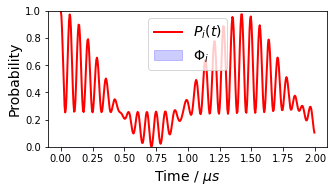

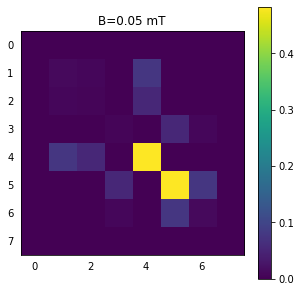

In [11]:
x = time * 1e6

fig = plt.figure()
plt.plot(x, time_evol, color="red", linewidth=2)
plt.fill_between(x, product_yield, color="blue", alpha=0.2)
plt.xlabel("Time / $\mu s$", size=14)
plt.ylabel("Probability", size=14)
plt.ylim([0, 1])
plt.legend([r"$P_i(t)$", r"$\Phi_i$"], fontsize=14)
fig.set_size_inches([5, 2.5])

fig = plt.figure()
plt.imshow(np.abs(rhos[1, 1]))
plt.title(f"B={B0} mT")
plt.tick_params(bottom=False, left=False)
plt.colorbar()
ax = plt.gca()
fig.set_size_inches([5, 5])


print(f"PY = {product_yield_sum}")